<a href="https://colab.research.google.com/github/MichelePrimavera/AutomatedFieldsPrediction/blob/main/AutomatedFieldsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Automated Prediction of Categorical Fields in Data Entry Forms by using Bayesian Networks

## *Introduction*

Users frequently engage with software systems via data entry forms, which are often time-consuming and prone to errors. While various techniques have been suggested to auto-complete or pre-fill form fields, these methods offer limited assistance for filling categorical fields, where users must select the correct value from a large set of options. In this article, I propose a method to predict field values based on historical data using Bayesian networks. Bayesian networks are probabilistic graphical models that represent a set of variables and their conditional dependencies through a directed acyclic graph. By leveraging these networks, we can efficiently capture the relationships between different fields and use this information to make informed predictions, thereby enhancing the form-filling process.

The goal is to provide code that works on a simple configuration of a JSON that describes the structure of the form + the field relationships.

Examples of application:
* Helping the user to fill back office forms;
* Test Automation;
* Finding patterns.


## Small introduction to Bayesian Networks (BN)

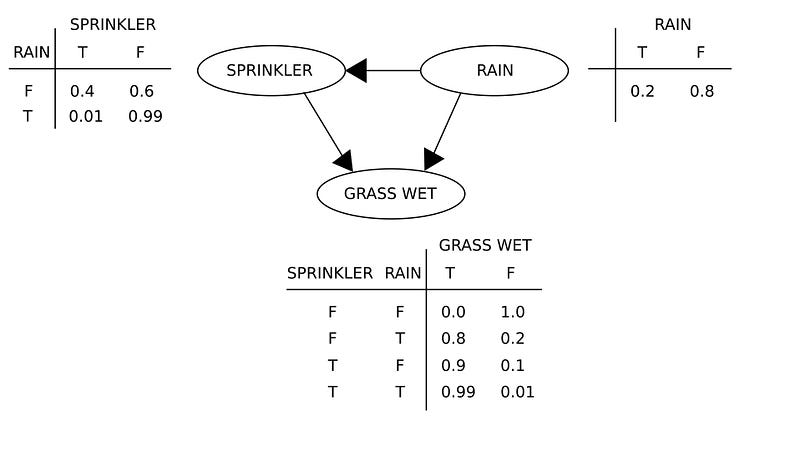

The Bayesian network represents a set of variables and their conditional dependencies, as shown in the directed acyclic graph (DAG). The graph is composed of nodes, each of which represents a random variable, and the edges between them depict the conditional dependencies that exist between the variables. The first step in building a Bayesian network is to quantify these dependencies both in strength and nature and as the coefficients of the conditional probability distribution.

Key components of a BN are:

* Nodes. The nodes are random variables, which can be observable values, latent variables, unknown parameters, or hypotheses.
* Edges:.A direct link from one node to another represents a conditional dependence. Such a connection from node A to node B shows that node B is conditionally dependent on node A.
* Conditional Probability Tables (CPTs). A CPT table is linked to each node and demonstrates how the parent nodes have an influence on nodes. This table shows the likelihood of each possible node state, given the states of its parent nodes.

Initially, the Bayesian network was used to confirm dependencies among discrete random variables. This is an algorithm that is expected to provide a practical solution even if there have been several missing observable variables. That is to say, the BN helps detect which discrete random unknown variables are likely to appear when some conditionally independent observable variables are missing.


To learn more → https://towardsdatascience.com/introduction-to-bayesian-networks-81031eeed94e

## Code



The requirements for the projects are:


*   pgmpy - https://pgmpy.org/models/bayesiannetwork.html
*   pandas - https://pandas.pydata.org/
*   itertools - https://docs.python.org/3/library/itertools.html

In [ ]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import pandas as pd
from pgmpy.factors.discrete import TabularCPD
from itertools import product
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

Then, I define:


* The user history. The prediction will be done from the historical data of a user;
* States. A list of values for each field of the form;
* Relationship. The fields can depend from each other.



In [ ]:
user_history = [
    {"category": "event", "type": "payment", "risk": "high", "range": "1000-10000"},
    {"category": "event", "type": "payment", "risk": "high", "range": "1000-10000"},
    {"category": "event", "type": "payment", "risk": "", "range": ""},
    {"category": "event", "type": "investment", "risk": "low", "range": "0-1000"},
    {"category": "event", "type": "investment", "risk": "low", "range": "0-1000"},
    {"category": "medical", "type": "payment", "risk": "middle", "range": "1000-10000"},
    {"category": "medical", "type": "payment", "risk": "middle", "range": "1000-10000"},
    {"category": "medical", "type": "investment", "risk": "high", "range": "+10000"},
    {"category": "medical", "type": "investment", "risk": "low", "range": "0-1000"},
    {"category": "medical", "type": "investment", "risk": "low", "range": "0-1000"},
    {"category": "medical", "type": "investment", "risk": "low", "range": "0-1000"},
    {"category": "sport", "type": "payment", "risk": "low", "range": "0-1000"},
    {"category": "sport", "type": "investment", "risk": "middle", "range": "1000-10000"},
    {"category": "event", "type": "payment", "risk": "low", "range": "0-1000"},
    {"category": "event", "type": "payment", "risk": "low", "range": "0-1000"},
    {"category": "event", "type": "investment", "risk": "middle", "range": "1000-10000"},
    {"category": "event", "type": "investment", "risk": "", "range": ""},
    {"category": "medical", "type": "payment", "risk": "high", "range": "+10000"},
    {"category": "medical", "type": "payment", "risk": "middle", "range": "1000-10000"},
    {"category": "medical", "type": "investment", "risk": "low", "range": "0-1000"},
    {"category": "sport", "type": "payment", "risk": "middle", "range": "1000-10000"},
    {"category": "sport", "type": "investment", "risk": "high", "range": "+10000"},
    {"category": "sport", "type": "investment", "risk": "high", "range": "0-1000"}
]
df = pd.DataFrame(user_history)

# Defining the values of each field (The "states" for CPD)
states = {
    "category": ["", "event", "medical", "sport"],
    "type": ["", "payment", "investment"],
    "risk": ["", "high", "middle", "low"],
    "range": ["", "0-1000", "1000-10000", "+10000"]
}

# Defining the relationship between the fields
relationships = {
    "type": ["category"],
    "risk": ["type"],
    "range": ["type", "risk"]
}

The main purpose of the "calculate_cpd" function is to calculate the conditional probability distribution for each set of the dependencies defined in the JSON. As we know, by summing the probabilities we should obtain 1. In addition, the function normalizes the frequencies and ensures that the calculated probabilities are consistent with the defined properties. In the case of data without parents, the function assigns the same probability to each variable.






In [ ]:
def calculate_cpd(variable, parents, df, states):
    """
    Calculate the Conditional Probability Distribution for a variable given its parents.
    """
    # Initialize frequency dictionary
    if not parents:
        frequency_dict = {v: 0 for v in states[variable]}
    else:
        frequency_dict = {comb: {v: 0 for v in states[variable]} for comb in product(*[states[p] for p in parents])}

    # Calculate frequencies
    for _, row in df.iterrows():
        if not parents:
            frequency_dict[row[variable]] += 1
        else:
            parent_values = tuple(row[p] for p in parents)
            frequency_dict[parent_values][row[variable]] += 1

    # Normalize to get probabilities
    if not parents:
        total = sum(frequency_dict.values())
        probabilities = {k: round(v / total, 2) if total > 0 else round(1/len(states[variable]), 2) for k, v in frequency_dict.items()}
    else:
        probabilities = {}
        for parent_values, counts in frequency_dict.items():
            total = sum(counts.values())
            if total > 0:
                probabilities[parent_values] = {k: round(v / total, 2) for k, v in counts.items()}
            else:
                probabilities[parent_values] = {k: round(1/len(states[variable]), 2) for k in states[variable]}

    # Prepare the CPD values
    if not parents:
        cpd_values = [[probabilities[v]] for v in states[variable]]
    else:
        cpd_values = [[probabilities[parent_values][v] for parent_values in product(*[states[p] for p in parents])] for v in states[variable]]

    # Create TabularCPD
    cpd = TabularCPD(
        variable=variable,
        variable_card=len(states[variable]),
        values=cpd_values,
        evidence=parents if parents else None,
        evidence_card=[len(states[p]) for p in parents] if parents else None
    )

    return cpd

For our example, the CPD to calculate are:


*   P(risk|type)
*   P(range|type,risk)
*   P(category)
*   P(type|category)

Based on relationship, this is how our newtork looks like:


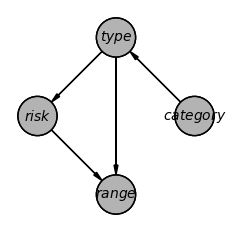

Below is the code to automatically calculate CPDs for all variables. I then created the model and tested it to ensure that each node had a properly defined Conditional Probability Distribution (CPD) matching its parents. It also ensures that the probabilities in the CPDs for each variable equal to one, maintaining the properties of probability distributions.

In [ ]:
# Calculate and print CPDs based on relationships
cpds = {}

# Automatically calculate CPDs for all variables
variables = set(relationships.keys()).union(*relationships.values())
for variable in variables:
    parents = relationships.get(variable, [])
    cpd = calculate_cpd(variable, parents, df, states)
    cpds[variable] = cpd
    print(f"CPD for {variable} given {parents}:\n{cpd}\n")

# Automatically define the structure of the Bayesian Network based on relationships
edges = [(parent, child) for child, parents in relationships.items() for parent in parents]
print("Edges:", edges)

# Define the Bayesian Network
model = BayesianNetwork(edges)

# Add CPDs to the network
model.add_cpds(*cpds.values())

# Check if the model is valid
assert model.check_model()

CPD for category given []:
+-------------+------+
| category(0) | 0    |
+-------------+------+
| category(1) | 0.39 |
+-------------+------+
| category(2) | 0.39 |
+-------------+------+
| category(3) | 0.22 |
+-------------+------+

CPD for type given ['category']:
+----------+-------------+-------------+-------------+-------------+
| category | category(0) | category(1) | category(2) | category(3) |
+----------+-------------+-------------+-------------+-------------+
| type(0)  | 0.33        | 0.0         | 0.0         | 0.0         |
+----------+-------------+-------------+-------------+-------------+
| type(1)  | 0.33        | 0.56        | 0.44        | 0.4         |
+----------+-------------+-------------+-------------+-------------+
| type(2)  | 0.33        | 0.44        | 0.56        | 0.6         |
+----------+-------------+-------------+-------------+-------------+

CPD for range given ['type', 'risk']:
+----------+---------+---------+---------+-----+---------+---------+----

Finally, the model can be tested by giving a user input and by defining the variables we want to predict:

In [ ]:
inference = VariableElimination(model)

# Function to perform inference based on user input
def perform_inference(evidence, variables):
    query = inference.map_query(variables=variables, evidence=evidence)
    return query

# Example: User input to infer node 'C' given A='test' and B='cipolla'
user_input = {'category': 2}
result = perform_inference(user_input, ['type'])
print("Inference result based on user input:", result)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Inference result based on user input: {'type': 2}


The result make sense due to the CPD:

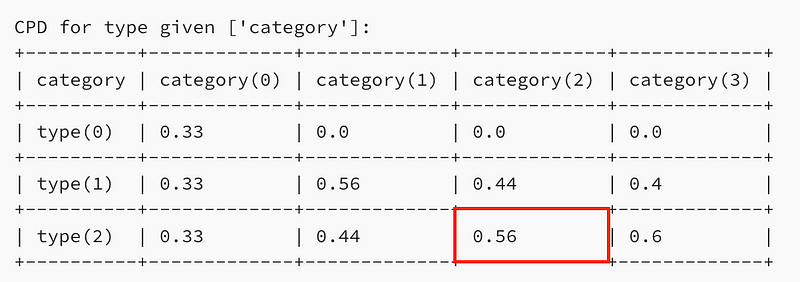

We can also test more complex case like:

In [ ]:
user_input = {'category': 2, "type": 1}
result = perform_inference(user_input, ['risk', "range"])
print("Inference result based on user input:", result)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Inference result based on user input: {'range': 2, 'risk': 2}


## Wrapping up
The approach utilizes Bayesian Networks to learn field dependencies from historical input instances. The code provided necessitates only a few simple JSON to work.